<a href="https://colab.research.google.com/github/mariaeco/imersao-dados-desafio-final/blob/main/Investiga%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PROJETO IMERSÃO ALURA

Esse projeto foi inspirado em um desafio do Laboratory innovation science at Harvard disponibilizando os dados em uma competição no Kaggle.

**Perguntas Iniciais:**

1) Quais compostos tiveram algum efeito na ativação dos genes? Se o composto não teve efeito, não continuar a análise com ele. (Não significa que não ter efeito não é importante, se um composto for ruim, então é bom que ele não tenha efeito)

2) Se apresentaram efeito, quais apresentaram efeito positivo sobre a ativação do gene e quais apresentaram efeito negativo?

3) Qual o mecanismo de ação (banco de dados 2) principal para o efeito sobre o gene?

**Importante**
A quantidade de genes e compostos é enorme. Como trabalhar com isso? Selecionar o que vamos trabalhar? Então saber se o composto não teve efeito já é uma eliminação de variáveis. Mas as vezes um composto tem efeito sobre um gene ou grupo de genes e sobre outros não. Como tratar isso?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Planilha dos Experimentos e Resultados
o que é o banco experimento e o que é o resposta?
g são as expressões gênicas - que são respostas
c são as células que receberam os tratamentos - o valor é a viabilidade

In [3]:
dados_exp = pd.read_csv('https://github.com/mariaeco/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true', compression = 'zip')
dados_exp.columns = dados_exp.columns.str.replace('-', '')
dados_exp.rename(columns={'droga': 'composto'}, inplace=True)
dados_exp

,id,tratamento,tempo,dose,composto,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,c60,c61,c62,c63,c64,c65,c66,c67,c68,c69,c70,c71,c72,c73,c74,c75,c76,c77,c78,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88,c89,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.6456,0.0136,-0.5141,-0.6320,0.7166,...

In [4]:
dados_resultados = pd.read_csv('https://github.com/mariaeco/imersao-dados-desafio-final/blob/main/Dados/dados_resultados.csv?raw=true')
dados_resultados

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Merge

In [5]:
dados = pd.merge(dados_exp, dados_resultados, on='id')
#renomeando pra ficar mais bonito
dados.sort_values(['tratamento', 'composto', 'dose'], inplace=True)
dados['composto'] = dados['composto'].replace({'cacb2b860': 'Controle'})
dados['tratamento'] = dados['tratamento'].replace({'com_controle': 'Controle','com_droga': 'Tratamento' })
dados

,id,tratamento,tempo,dose,composto,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
25,id_0054388ec,Controle,48,D1,Controle,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,0.7785,0.7062,-0.7951,1.3770,0.2856,-0.8331,0.3879,1.3290,-0.4746,0.0857,-0.2745,-0.1093,0.2603,0.7386,-0.6665,-1.6520,-0.9262,0.0000,1.6310,-0.2933,0.2043,-2.2070,0.1383,-0.4966,0.6922,-0.4077,0.2303,-0.0456,-0.7447,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38,id_0079af0fb,Controle,24,D1,Controle,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,0.3856,-0.1670,-0.5400,0.2721,-0.2479,0.0761,-0.4054,2.9760,-0.7679,0.6995,0.0752,0.5943,0.4266,0.0000,1.0410,-0.1131,0.6593,-0.6890,0.5115,-0.2512,-0.8775,-1.3810,0.1419,-0.0363,0.2559,2.5290,0.2853,1.4690,-0.3626,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
81,id_00d575cfb,Controle,72,D1,Controle,-0.6723,-0.1206,0.3467,-0.6395,-0.3117,1.2260,0.5376,0.4072,0.1072,0.2999,-0.5951,0.3314,-0.6563,-0.5825,-0.3253,-0.2861,1.8600,-0.2175,0.0644,-0.8179,0.5433,1.2210,-0.3418,0.0000,1.5970,0.3848,0.9079,-0.8118,-0.0735,-0.7087,0.3599,-0.2125,0.2554,0.1326,-1.0840,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
148,id_01b05de6c,Controle,48,D1,Controle,-0.3176,0.8375,-0.3773,0.5555,-0.4877,0.3413,-0.8204,-1.1320,1.0220,2.8340,1.5950,-0.4357,2.4850,0.0169,0.3497,0.2446,0.9030,1.0480,-0.0236,0.1287,-0.2542,-0.9599,-1.2090,0.8248,1.2270,0.9403,1.2220,0.7952,0.0654,0.1419,0.4826,-0.3608,-1.2470,0.8987,-1.6590,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
175,id_01f1c58a2,Controle,72,D1,Controle,1.1220,0.7841,-0.4374,-0.0314,-0.4130,0.5947,0.8534,0.0790,0.3800,-0.2035,0.2127,-0.4461,1.0430,0.2279,0.0566,0.0000,-0.3716,0.1550,0.3925,-0.0826,0.1344,1.5450,-0.3988,0.7190,0.6027,-0.7236,0.9727,-0.7076,0.7918,-0.4296,-0.6394,0.1831,0.5052,0.0070,-0.6597,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22773,id_f48c19472,Tratamento,72,D1,fff7d208d,0.5408,-1.4560,-0.1473,0.4003,0.2285,0.3690,1.1740,-0.5140,-1.0500,-0.4816,0.4252,-0.7625,1.5500,1.2170,0.3908,-1.3730,0.5137,0.4466,1.1670,0.2632,0.1771,-0.3740,0.8383,-2.0820,-0.3954,1.4400,0.4031,0.3557,0.9868,0.7782,0.4559,-0.1629,0.2494,-0.1824,0.5438,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23637,id_fdf860f5f,Tratamento,24,D1,fff7d208d,0.3602,0.1099,-0.2263,0.3325,0.6581,-0.6463,0.1821,-0.4568,-0.3015,0.0829,-0.3963,-0.1849,1.0660,0.8443,0.7604,-0.5483,0.0097,0.5490,0.3318,0.0000,-1.1260,-1.3260,0.6020,-1.0270,-0.7888,0.8839,-0.09

## Escolhendo qual subconjunto de dados trabalhar
* Escolhendo os compostos que vamos trabalhar com base no principio ativo, o principio ativo que tenha mais compostos

In [6]:
dados.drop(['id', 'tempo'], axis=1).select_dtypes('int64').sum(axis=0).sort_values(ascending=False).head(15)

nfkb_inhibitor                       832
proteasome_inhibitor                 726
cyclooxygenase_inhibitor             435
dopamine_receptor_antagonist         424
serotonin_receptor_antagonist        404
dna_inhibitor                        402
glutamate_receptor_antagonist        367
adrenergic_receptor_antagonist       360
cdk_inhibitor                        340
egfr_inhibitor                       336
tubulin_inhibitor                    316
acetylcholine_receptor_antagonist    301
pdgfr_inhibitor                      297
hmgcr_inhibitor                      283
calcium_channel_blocker              281
dtype: int64

Com base no resultado acima ficou notável que o princípio ativo ```nfkb``` foi o que apresentou a maior quantidade de compostos
Vamos trabalhar com ele inicialmente

In [8]:
sub_data = dados.query('nfkb_inhibitor > 0 | tratamento == "Controle"')
sub_data
# é o mesmo que dados[(dados['nfkb_inhibitor'] > 0) | (dados['tratamento']=='com_controle')]

,id,tratamento,tempo,dose,composto,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
25,id_0054388ec,Controle,48,D1,Controle,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,0.7785,0.7062,-0.7951,1.3770,0.2856,-0.8331,0.3879,1.3290,-0.4746,0.0857,-0.2745,-0.1093,0.2603,0.7386,-0.6665,-1.6520,-0.9262,0.0000,1.6310,-0.2933,0.2043,-2.2070,0.1383,-0.4966,0.6922,-0.4077,0.2303,-0.0456,-0.7447,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38,id_0079af0fb,Controle,24,D1,Controle,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,0.3856,-0.1670,-0.5400,0.2721,-0.2479,0.0761,-0.4054,2.9760,-0.7679,0.6995,0.0752,0.5943,0.4266,0.0000,1.0410,-0.1131,0.6593,-0.6890,0.5115,-0.2512,-0.8775,-1.3810,0.1419,-0.0363,0.2559,2.5290,0.2853,1.4690,-0.3626,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
81,id_00d575cfb,Controle,72,D1,Controle,-0.6723,-0.1206,0.3467,-0.6395,-0.3117,1.2260,0.5376,0.4072,0.1072,0.2999,-0.5951,0.3314,-0.6563,-0.5825,-0.3253,-0.2861,1.8600,-0.2175,0.0644,-0.8179,0.5433,1.2210,-0.3418,0.0000,1.5970,0.3848,0.9079,-0.8118,-0.0735,-0.7087,0.3599,-0.2125,0.2554,0.1326,-1.0840,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
148,id_01b05de6c,Controle,48,D1,Controle,-0.3176,0.8375,-0.3773,0.5555,-0.4877,0.3413,-0.8204,-1.1320,1.0220,2.8340,1.5950,-0.4357,2.4850,0.0169,0.3497,0.2446,0.9030,1.0480,-0.0236,0.1287,-0.2542,-0.9599,-1.2090,0.8248,1.2270,0.9403,1.2220,0.7952,0.0654,0.1419,0.4826,-0.3608,-1.2470,0.8987,-1.6590,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
175,id_01f1c58a2,Controle,72,D1,Controle,1.1220,0.7841,-0.4374,-0.0314,-0.4130,0.5947,0.8534,0.0790,0.3800,-0.2035,0.2127,-0.4461,1.0430,0.2279,0.0566,0.0000,-0.3716,0.1550,0.3925,-0.0826,0.1344,1.5450,-0.3988,0.7190,0.6027,-0.7236,0.9727,-0.7076,0.7918,-0.4296,-0.6394,0.1831,0.5052,0.0070,-0.6597,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10529,id_7178e42ef,Tratamento,24,D1,f60388237,0.2693,0.9886,0.1210,-0.4752,-0.3997,-1.7820,-1.0060,1.3100,-0.4478,1.4990,-1.2080,-1.7410,0.8301,-0.1715,-1.9990,0.0348,-0.7874,0.0087,0.1693,0.7240,-1.5570,-0.0800,-0.9423,-0.1714,-0.3942,-0.1990,0.5888,-1.3240,-0.7402,-0.2822,-0.2708,0.1447,0.5850,-0.4957,1.1590,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17096,id_b810ccd1c,Tratamento,48,D1,f60388237,-0.1013,0.1885,-0.1874,0.5962,-0.0206,-0.0087,-1.2070,0.8762,-0.5401,-1.1610,0.6889,0.0460,-0.5643,-0.6220,-0.7289,0.4890,-0.3350,0.4488,0.2506,-0.0421,-0.4553,0.1079,0.3494,0.0000,-0.3316,

In [12]:
len(sub_data.composto.unique()) # de sub_data reduzi para 19 sendo 1 o controle

20

In [13]:
sub_data.tratamento.value_counts()

Controle      1866
Tratamento     832
Name: tratamento, dtype: int64

In [14]:
sub_data.composto.value_counts(ascending=False)[:8]

Controle     1866
87d714366     718
50e38451f      12
508e74297       7
02b14dcc0       6
b1b429d55       6
b79576a34       6
d2d7e1eab       6
Name: composto, dtype: int64

**Vemos acima que:**

---



1) o Controle tem bastante réplica

2) Temos o composto '87d714366' com 718 amostras, as quais são: 718/2 doses/ 3 tempos =~ 120 replicas

3) O composto '50e38451f' com 12 amostras, sendo: 12/2/3 = 2 réplicas

4) o restante dos compostos com 7/6 anmostras que terão apenas **1 réplica** (6/3/2), ou seja, são compostos que não podemos usá-los para a análise se não tiverem inseridos dentro de um grupo, pois uma réplica não representa nada.

*Vamos explorar um pouco mais abaixo, e avaliar se mantemos eles como nfkb_inhibitor ou não.*

#### EXPLORAÇÃO DOS DADOS


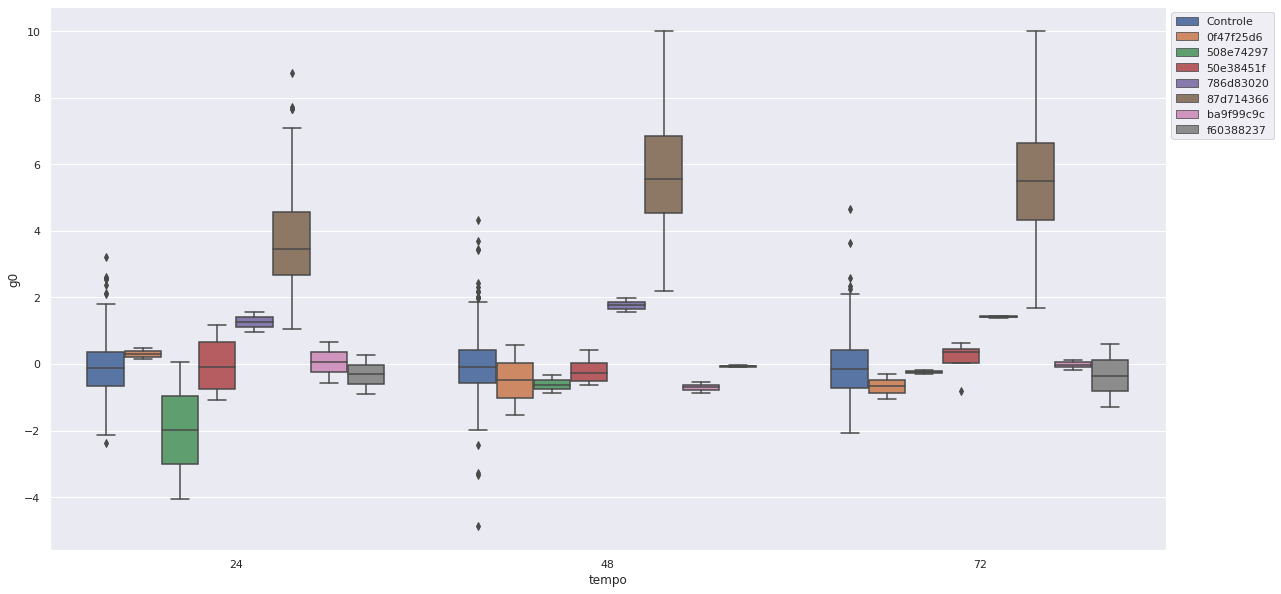

In [ ]:
sns.set()
cod_compostos = sub_data.composto.value_counts().index[:8]
selected_compostos =sub_data.query('composto in @cod_compostos')
selected_compostos.head()

plt.figure(figsize=(20,10))
sns.boxplot(data=selected_compostos, x='tempo', y='g0', hue='composto')
plt.legend(bbox_to_anchor=(1,1), loc=2);

In [ ]:
sub_data['composto'].value_counts()

Controle     1866
87d714366     718
50e38451f      12
508e74297       7
9f9f2cc3e       6
0fa4c6156       6
3ee3c4f73       6
b1b429d55       6
ba9f99c9c       6
b79576a34       6
b5e8fd5b5       6
0f47f25d6       6
d2d7e1eab       6
6d4b8a98c       6
f60388237       6
91dc8bab8       6
02b14dcc0       6
838575b1d       6
786d83020       6
f344437e0       5
Name: composto, dtype: int64

In [ ]:
sub_data.query('composto != "Controle"')['composto'].value_counts(normalize=True)*100

87d714366    86.298077
50e38451f     1.442308
508e74297     0.841346
02b14dcc0     0.721154
0f47f25d6     0.721154
6d4b8a98c     0.721154
f60388237     0.721154
ba9f99c9c     0.721154
b79576a34     0.721154
0fa4c6156     0.721154
838575b1d     0.721154
91dc8bab8     0.721154
d2d7e1eab     0.721154
b5e8fd5b5     0.721154
3ee3c4f73     0.721154
9f9f2cc3e     0.721154
b1b429d55     0.721154
786d83020     0.721154
f344437e0     0.600962
Name: composto, dtype: float64

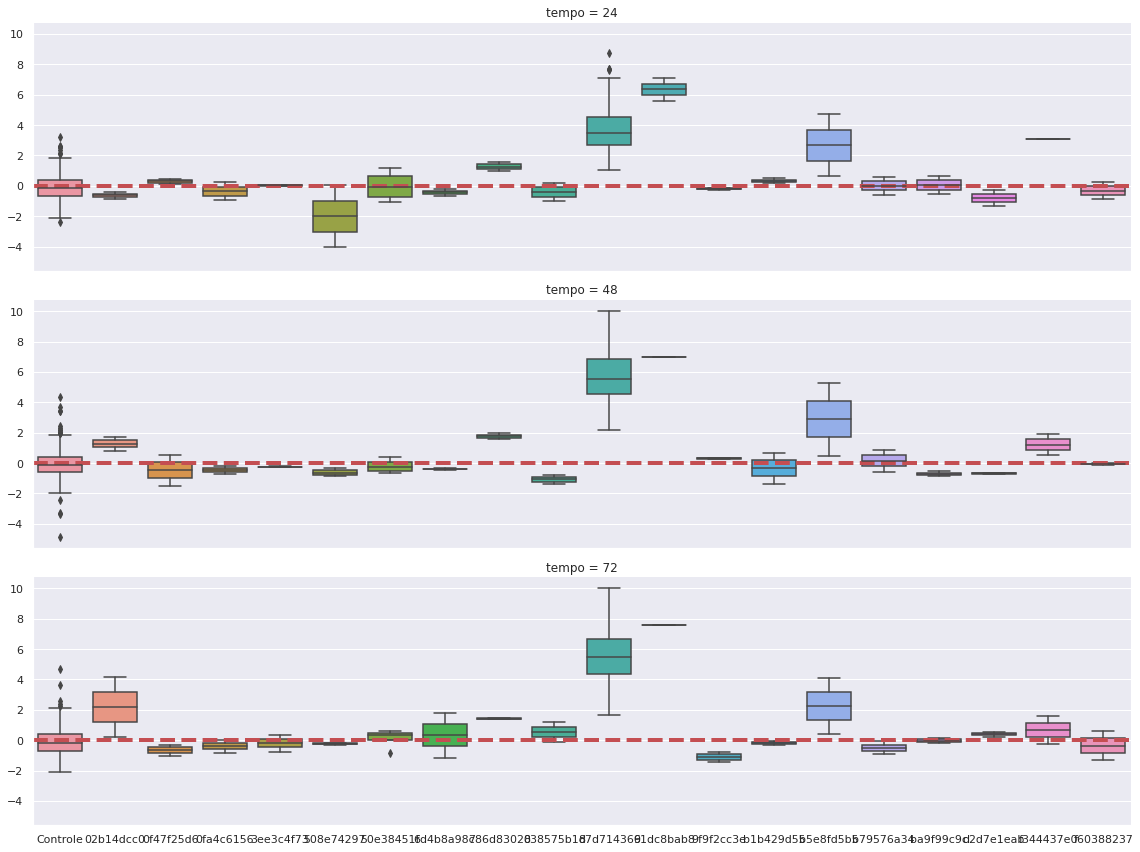

In [ ]:
#@title
sns.set()
g = sns.catplot(x="composto", y="g0", #hue = dose
                col="tempo",col_wrap=1, 
                data=selected_compostos, kind="box",
                height=4, aspect=4);
g.map(plt.axhline, y=0, color = 'r', ls = '--', linewidth=4);


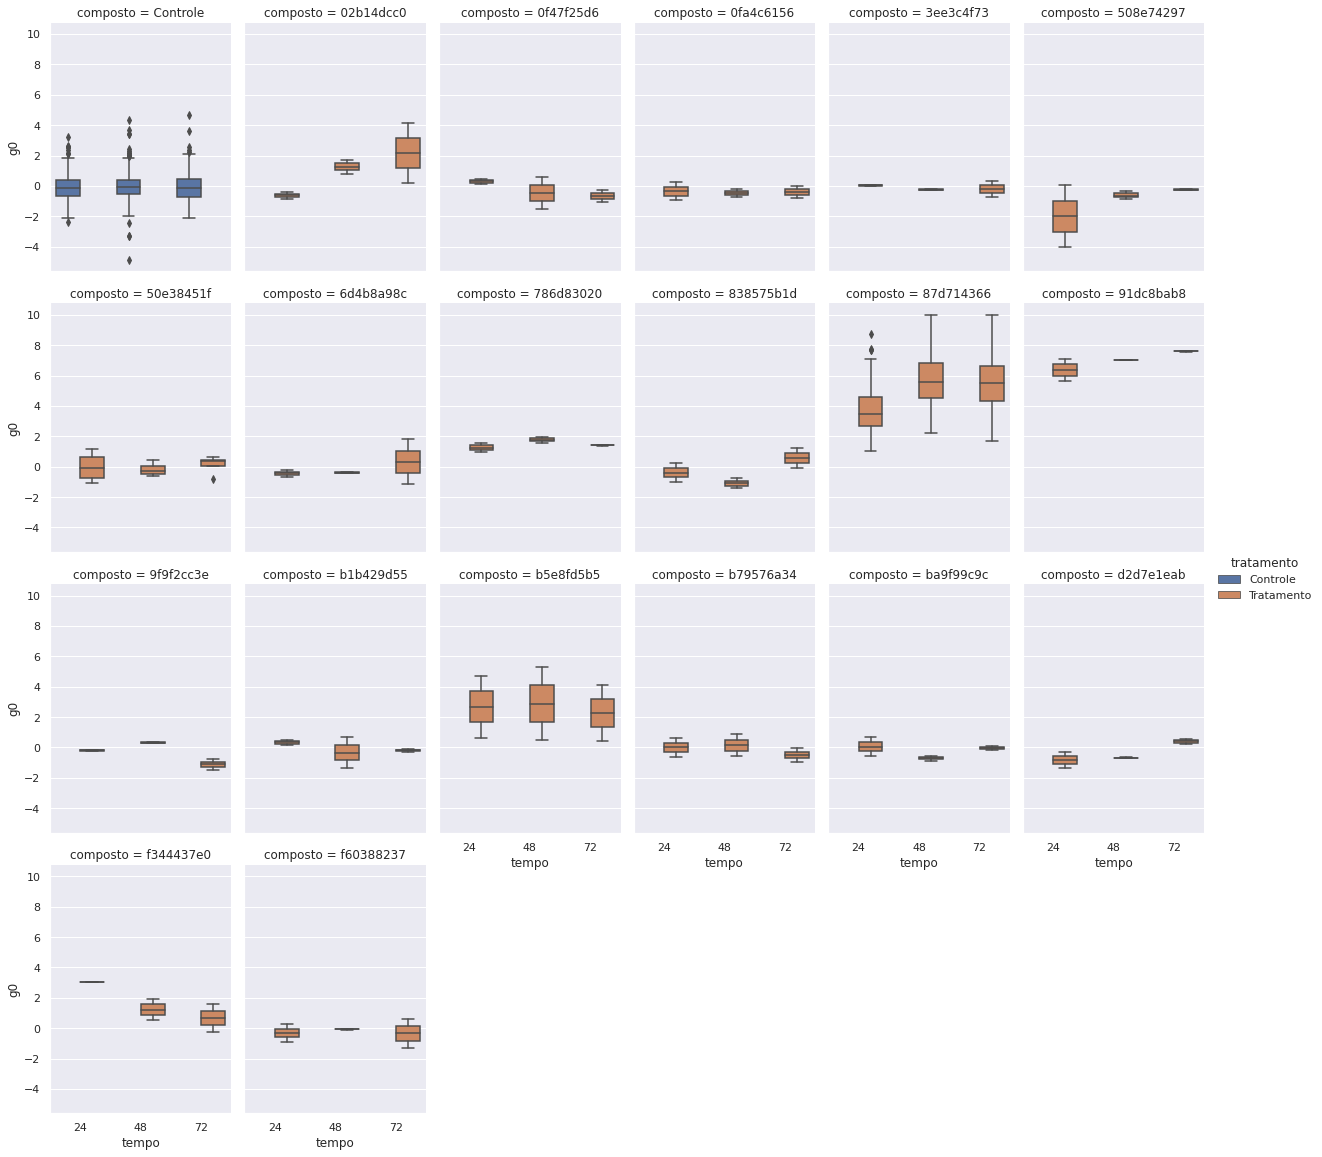

In [ ]:
sns.set()
g = sns.catplot(x="tempo", y="g0",
                hue="tratamento",col="composto",col_wrap=6,
                data=selected_compostos, kind="box",
                height=4, aspect=.7);

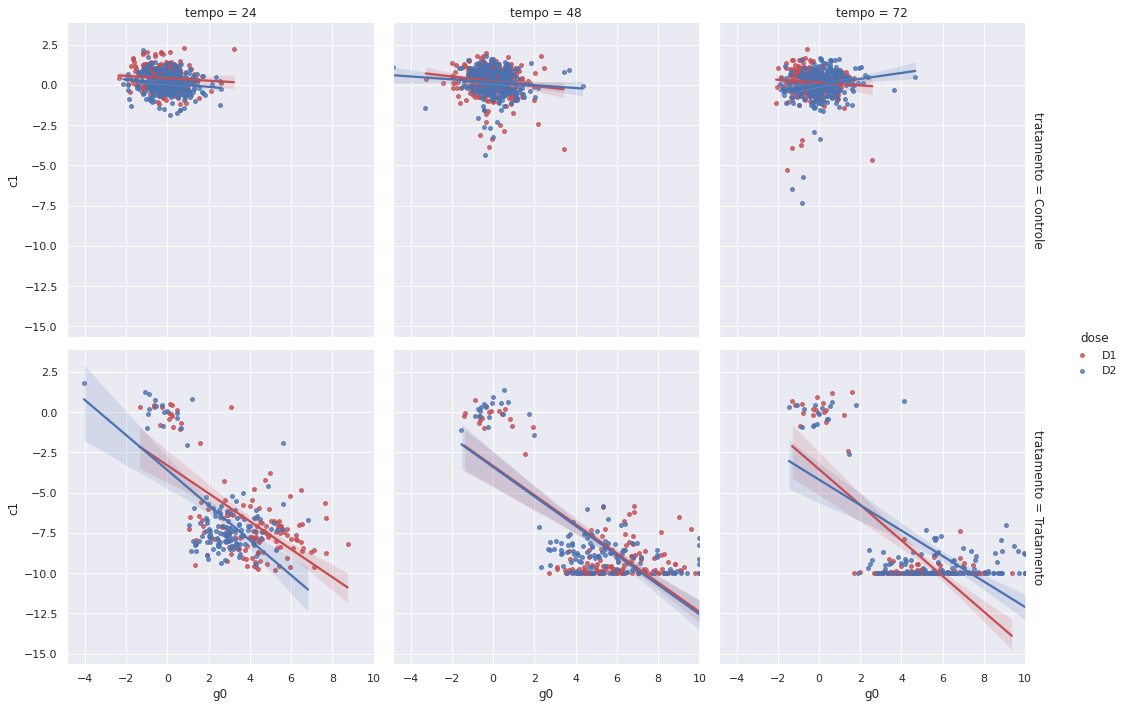

In [ ]:
g = sns.FacetGrid(data=sub_data, row='tratamento', col='tempo', hue='dose', palette=dict(D1='r', D2='b'), margin_titles=True, height=5)
g.map(sns.regplot, 'g0', 'c1', fit_reg=True, scatter_kws={"s": 15},)
g.add_legend();

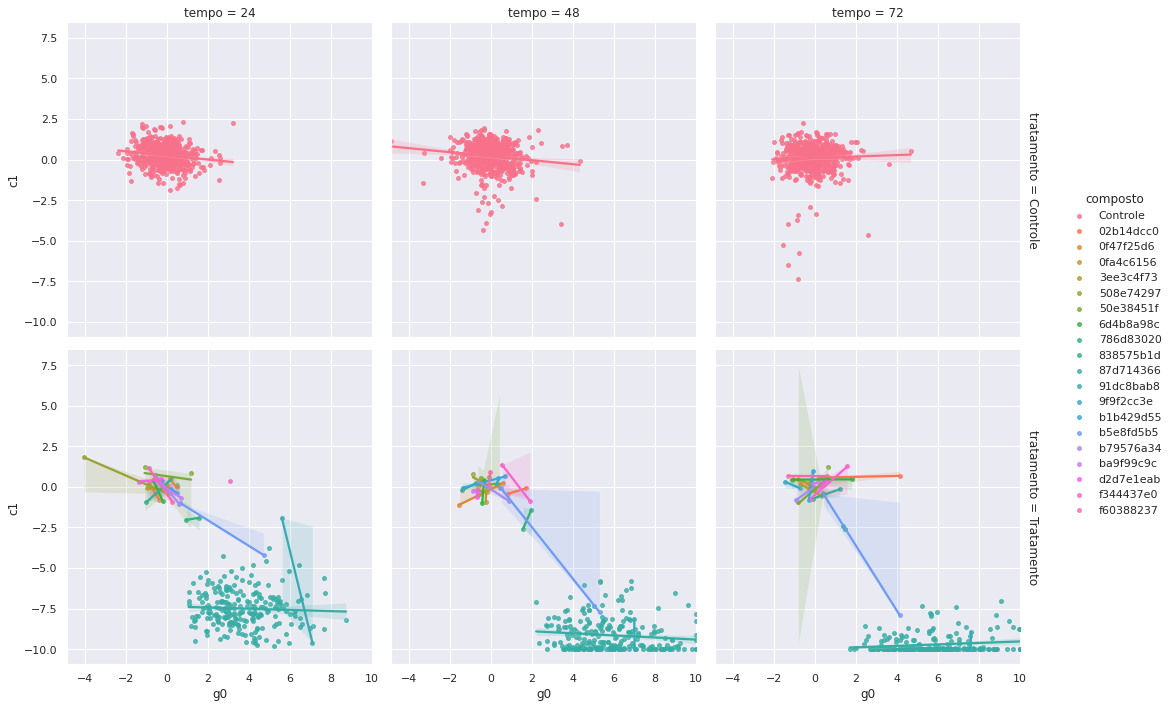

In [ ]:
g = sns.FacetGrid(data=sub_data, row='tratamento', col='tempo', hue='composto',  margin_titles=True, height=5)
g.map(sns.regplot, 'g0', 'c1', fit_reg=True, scatter_kws={"s": 15})
g.add_legend();

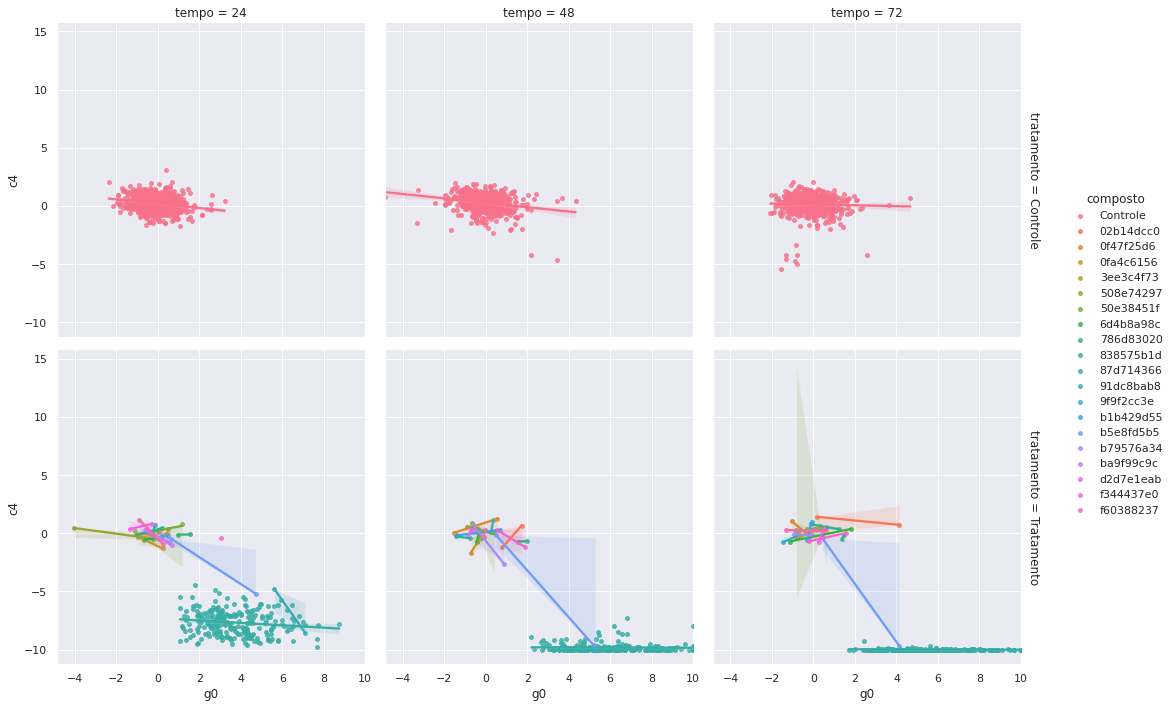

In [ ]:
g = sns.FacetGrid(data=sub_data, row='tratamento', col='tempo', hue='composto',  margin_titles=True, height=5)
g.map(sns.regplot, 'g0', 'c4', fit_reg=True, scatter_kws={"s": 15})
g.add_legend();

##### E se pegarmos apenas as linhas com o composto "87d714366"?

In [ ]:
sub_data.query('composto != "Controle"')['composto'].value_counts(normalize=True)*100

87d714366    86.298077
50e38451f     1.442308
508e74297     0.841346
ba9f99c9c     0.721154
b5e8fd5b5     0.721154
838575b1d     0.721154
786d83020     0.721154
0fa4c6156     0.721154
6d4b8a98c     0.721154
0f47f25d6     0.721154
3ee3c4f73     0.721154
9f9f2cc3e     0.721154
91dc8bab8     0.721154
b79576a34     0.721154
d2d7e1eab     0.721154
f60388237     0.721154
02b14dcc0     0.721154
b1b429d55     0.721154
f344437e0     0.600962
Name: composto, dtype: float64

In [ ]:
composto_87d714366 = sub_data.query('composto == "Controle" | composto == "87d714366"')
print(f'Quantidade de linhas: {len(composto_87d714366)}')
print(f'Valores únicos da variável "composto":{composto_87d714366.composto.unique()}')
composto_87d714366.head()

Quantidade de linhas: 2584
Valores únicos da variável "composto":['Controle' '87d714366']


,id,tratamento,tempo,dose,composto,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
25,id_0054388ec,Controle,48,D1,Controle,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,0.7785,0.7062,-0.7951,1.3770,0.2856,-0.8331,0.3879,1.3290,-0.4746,0.0857,-0.2745,-0.1093,0.2603,0.7386,-0.6665,-1.6520,-0.9262,0.0000,1.6310,-0.2933,0.2043,-2.2070,0.1383,-0.4966,0.6922,-0.4077,0.2303,-0.0456,-0.7447,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38,id_0079af0fb,Controle,24,D1,Controle,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,0.3856,-0.1670,-0.5400,0.2721,-0.2479,0.0761,-0.4054,2.9760,-0.7679,0.6995,0.0752,0.5943,0.4266,0.0000,1.0410,-0.1131,0.6593,-0.6890,0.5115,-0.2512,-0.8775,-1.3810,0.1419,-0.0363,0.2559,2.5290,0.2853,1.4690,-0.3626,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
81,id_00d575cfb,Controle,72,D1,Controle,-0.6723,-0.1206,0.3467,-0.6395,-0.3117,1.2260,0.5376,0.4072,0.1072,0.2999,-0.5951,0.3314,-0.6563,-0.5825,-0.3253,-0.2861,1.8600,-0.2175,0.0644,-0.8179,0.5433,1.2210,-0.3418,0.0000,1.5970,0.3848,0.9079,-0.8118,-0.0735,-0.7087,0.3599,-0.2125,0.2554,0.1326,-1.0840,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
148,id_01b05de6c,Controle,48,D1,Controle,-0.3176,0.8375,-0.3773,0.5555,-0.4877,0.3413,-0.8204,-1.1320,1.0220,2.8340,1.5950,-0.4357,2.4850,0.0169,0.3497,0.2446,0.9030,1.0480,-0.0236,0.1287,-0.2542,-0.9599,-1.2090,0.8248,1.2270,0.9403,1.2220,0.7952,0.0654,0.1419,0.4826,-0.3608,-1.2470,0.8987,-1.6590,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
175,id_01f1c58a2,Controle,72,D1,Controle,1.1220,0.7841,-0.4374,-0.0314,-0.4130,0.5947,0.8534,0.0790,0.3800,-0.2035,0.2127,-0.4461,1.0430,0.2279,0.0566,0.0000,-0.3716,0.1550,0.3925,-0.0826,0.1344,1.5450,-0.3988,0.7190,0.6027,-0.7236,0.9727,-0.7076,0.7918,-0.4296,-0.6394,0.1831,0.5052,0.0070,-0.6597,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


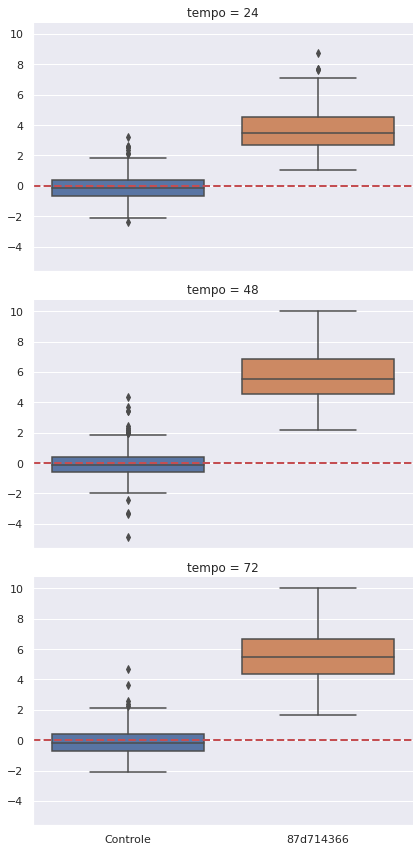

In [ ]:
sns.set()
g = sns.catplot(x="composto", y="g0", #hue = dose
                col="tempo",col_wrap=1, 
                data=composto_87d714366, kind="box",
                height=4, aspect=1.5);
g.map(plt.axhline, y=0, color = 'r', ls = '--', linewidth=2);

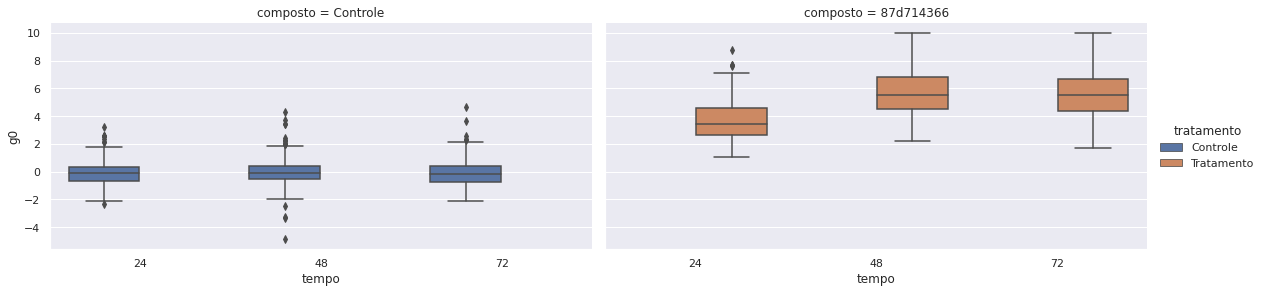

In [ ]:
sns.set()
g = sns.catplot(x="tempo", y="g0",
                hue="tratamento",col="composto",#col_wrap=6,
                data=composto_87d714366, kind="box",
                height=4, aspect=2);

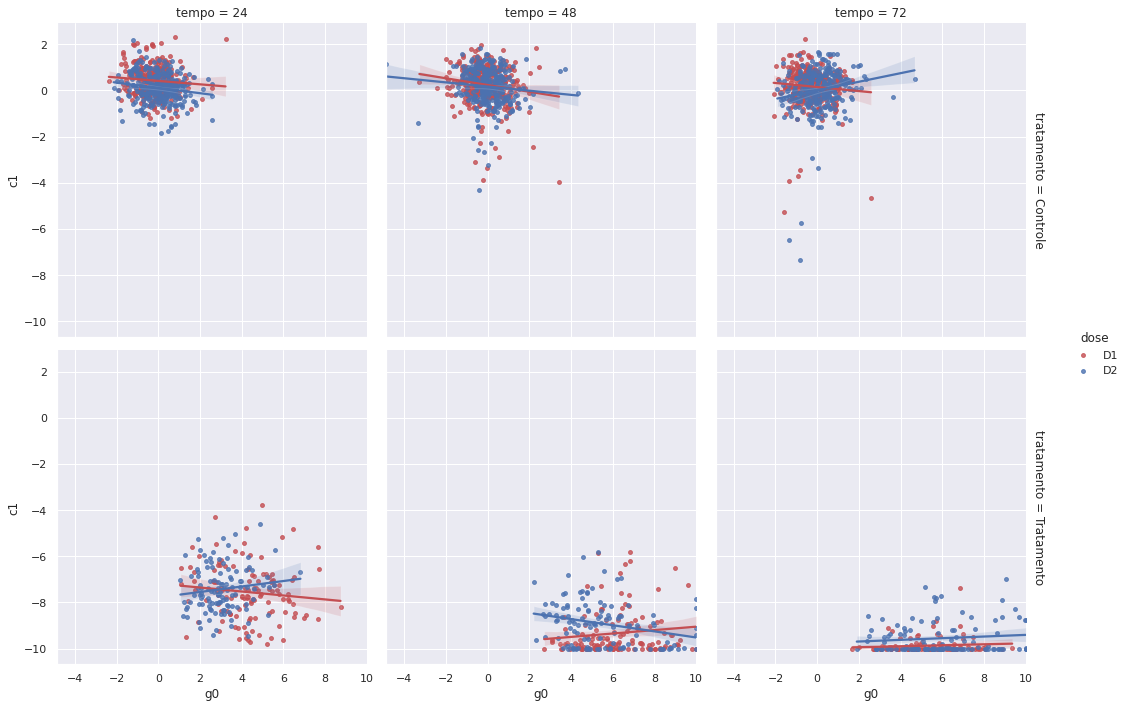

In [ ]:
g = sns.FacetGrid(data=composto_87d714366, row='tratamento', col='tempo', hue='dose', palette=dict(D1='r', D2='b'), margin_titles=True, height=5)
g.map(sns.regplot, 'g0', 'c1', fit_reg=True, scatter_kws={"s": 15},)
g.add_legend();

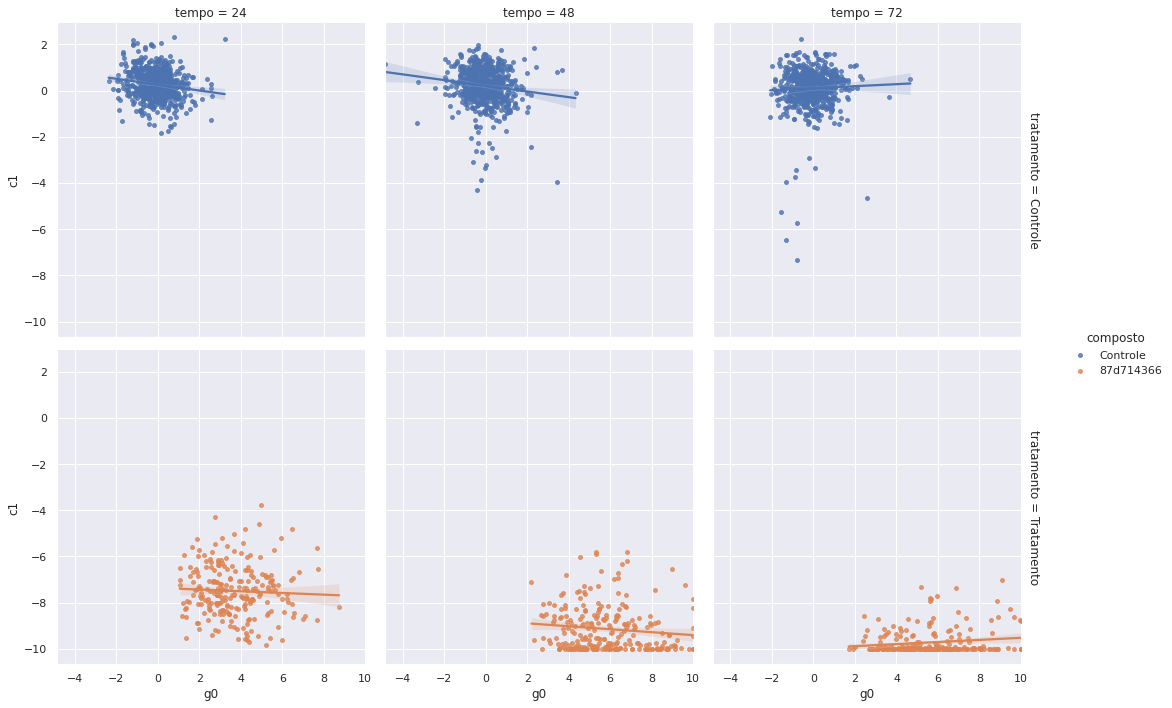

In [ ]:
g = sns.FacetGrid(data=composto_87d714366, row='tratamento', col='tempo', hue='composto',  margin_titles=True, height=5)
g.map(sns.regplot, 'g0', 'c1', fit_reg=True, scatter_kws={"s": 15})
g.add_legend();